In [5]:
# Imports
from typing import Union
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, GroupKFold

from xgboost import XGBRegressor

In [3]:
def load_raw_data(txt_filename: str) -> pd.DataFrame:
    """ Loads the .txt data from the Data folder as pandas DataFrame 
        :argument: txt_filename - name of the text file with .txt extension
        :return: dataframe - pandas DataFrame
    """
    # Define the data folder path
    data_path = Path().absolute().parent.joinpath('data', 'raw')
    # Open with pandas without header and space as separator
    train = pd.read_csv(data_path.joinpath(txt_filename), sep='\s+', header=None).dropna(axis=1, how='all')
    test = pd.read_csv(data_path.joinpath(txt_filename.replace('train', 'test')), sep='\s+', header=None).dropna(axis=1, how='all')
    y_test = pd.read_csv(data_path.joinpath(txt_filename.replace('train', 'RUL')), sep='\s+', header=None, names=['rul']).dropna(axis=1, how='all')
    # Define number of sensor columns
    sensors_number = len(train.columns) - 5
    # Rename the columns to corrensponding value
    column_names = ['unit', 'cycle', 'altitude', 'mach', 'tra'] + [f'sensor_{i}' for i in range(1, sensors_number + 1)]
    train.columns = column_names
    test.columns = column_names
    return train, test, y_test

def create_target(raw_data: pd.DataFrame) -> pd.DataFrame:
    """ Creates the RUL target variable based on max cycles from the dataset 
        :argument: raw_data - Pandas DataFrame containing training data
        :return: dataset - Pandas DataFrame containing training data and target variable
    """
    data = raw_data.copy()
    # Group the data by unit column and calculate the max cycle
    grouped = data.groupby('unit')
    max_cycle = grouped['cycle'].max()
    # Merge the max cycle back to the data
    data = data.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit', right_index=True)
    # Calculate difference between max cycle and current cycle, create RUL
    data['rul'] = data['max_cycle'] - data['cycle']
    # Drop the max cycle column
    data.drop('max_cycle', axis=1, inplace=True)
    return data

def round_conditions(data: pd.DataFrame) -> pd.DataFrame:
    """ Rounds the values of condition columns (altitude, mach, tra) """
    data['altitude'] = data['altitude'].round()
    data['mach'] = data['mach'].round(2)
    data['tra'] = data['tra'].round()
    # Concatenate all 3 conditions into 1
    data['condition'] = data['altitude'] + data['mach'] + data['tra']
    keys = data['condition'].unique()
    mapping = {k: v for k, v in zip(keys, range(1, len(keys) + 1))}
    data['condition'] = data['condition'].map(mapping)
    return data

def standardize(input_data: pd.DataFrame):
    """ Standardizes the sensor values based on condition to have same mean to be comparable """
    data = input_data.copy()
    sensors = [e for e in list(data.columns) if 'sensor_' in e]
    for condition in data['condition'].unique():
        for column in sensors:
            mean =  data.loc[data['condition'] == condition, column].mean()
            std = data.loc[data['condition'] == condition, column].std()
            data.loc[data['condition'] == condition,column] = data.loc[data['condition'] == condition, column].map(lambda x: (x - mean) / (std + 0.0000001))
    return data

def get_condition_stats(data: pd.DataFrame) -> pd.DataFrame:
    """ Computes the Mean and Std for every sensor based on certain condition """
    sensors = [e for e in list(data.columns) if 'sensor_' in e]
    means, stds, conditions = [], [], []
    sensor_names = []
    for condition in data['condition'].unique():
        for column in sensors:
            sensor_names.append(column)
            conditions.append(condition)
            means.append(data.loc[data['condition'] == condition, column].mean())
            stds.append(data.loc[data['condition'] == condition, column].std())
    stats = pd.DataFrame(list(zip(sensor_names, means, stds, conditions)), columns=['sensor_name','mean', 'std', 'condition'])
    return stats

def smooth_data(input_data: pd.DataFrame, window: int) -> pd.DataFrame:
    """ Smooths the sensor measurements with Moving Average and specified window 
        :argument: input_data - Pandas Dataframe containing data
        :argument: window - Integer representing the moving average window size
        :return: smoothed_data - Pandas Dataframe with smoothed sensor measurements
    """
    smoothed_data = input_data.copy()
    sensors = [e for e in list(smoothed_data.columns) if 'sensor_' in e]
    smoothed_data[sensors] = smoothed_data.groupby('unit')[sensors].apply(lambda column: column.rolling(window=window, min_periods=1).mean())
    return smoothed_data

# =========================================================================PLOTTING=============================================================================

def plot_histogram(data: pd.DataFrame, column: str, unit: str = None) -> None:
    """ Plots the histogram for specified column grouped by unit """
    if column == 'rul':
        data = data[['unit', column]].groupby('unit').max().reset_index()
        unit = None
    if unit:
        data = data[data['unit'] == unit]
    data[column].hist(bins=15, figsize=(10,6))
    plt.xlabel(column)
    plt.show()
    
def plot_sensors(input_data: pd.DataFrame, unit: str = None, condition: int = None) -> None:
    """ Plots the sensor values for given dataset and specified unit and condition """
    data = input_data.copy()
    sensor_names = [e for e in list(data.columns) if 'sensor_' in e]
    fig, axs = plt.subplots(len(sensor_names) // 2+1, 2, figsize=(20,60))
    if unit and condition:
        data = data[(data['unit'] == unit) & (data['condition'] == condition)]
    elif unit and not condition:
        data = data[data['unit'] == unit]
    elif condition and not unit:
        data = data[data['condition'] == condition]
        max_unit = data['unit'].max()
        random_units = np.random.randint(1, max_unit, size=10)
        print('Random units: ', random_units)
    else:
        max_unit = data['unit'].max()
        random_units = np.random.randint(1, max_unit, size=10)
        print('Random units: ', random_units)
    for i in range(11):
        for j in range(2):
            idx = j + i * 2 if j + i * 2 <= len(sensor_names)-1 else len(sensor_names)-1
            sensor_name = sensor_names[idx]
            if unit is None:
                for unit_number in random_units.tolist():
                    axs[i,j].plot('rul', sensor_name, data=data[data['unit'] == unit_number])
            else:
                axs[i,j].plot('rul', sensor_name, data=data)
            axs[i,j].set_xlim(300, 0) 
            axs[i,j].set_ylabel(sensor_name)
            axs[i,j].set_xlabel('RUL')
            axs[i,j].set_title(sensor_name)
            axs[i,j].grid(True, linewidth=0.5)
    plt.show()
    
def plot_condition(data: pd.DataFrame, unit: int, cond_column: str) -> None:
    """ Plotting condition values in respect to the RUL (line chart) """
    plt.figure(figsize=(15,5))
    plt.plot('rul', cond_column, '-', data=data[data['unit'] == unit])
    plt.xlim(200,0)
    plt.ylabel(cond_column)
    plt.show()
    
def plot_condition_stats(conditioned_stats: pd.DataFrame, sensor: str) -> None:
    """ Plotting mean values of the specific sensor for all conditions """
    fig, ax1 = plt.subplots(figsize=(12,5))
    # First Y axis (Mean)
    color_1 = 'tab:blue'
    ax1.plot('condition', 'mean', 'o-', data=conditioned_stats[conditioned_stats['sensor_name'] == sensor], color=color_1)
    ax1.set_xlabel('Condition')
    ax1.set_ylabel('Mean', color=color_1)
    ax1.tick_params(axis='y', labelcolor=color_1)
    # Second Y axis (Std)
    ax2 = ax1.twinx() 
    color_2 = 'tab:red'
    ax2.plot('condition', 'std', 'o-', data=conditioned_stats[conditioned_stats['sensor_name'] == sensor], color=color_2)
    ax2.set_ylabel('Std', color=color_2) 
    ax2.tick_params(axis='y', labelcolor=color_2)
    fig.tight_layout() 
    plt.show()
    # Show stats
    print(conditioned_stats[conditioned_stats['sensor_name'] == sensor])
    
def plot_residuals(pred, real) -> None:
    """ Plots the residual errors between the real and predicted value """
    # Calculate residual errors
    residuals = real - pred
    fig, axs = plt.subplots(nrows=1, ncols=2, squeeze=True, figsize=(20, 8))
    # Residuals Errors plot
    axs[0].scatter(x=pred, y=residuals, color='g', alpha=0.7)
    axs[0].axhline(y=0, linestyle='--', color='black', linewidth=3.5)
    axs[0].set_xlabel('Estimations', fontsize=17)
    axs[0].set_ylabel('Residuals', fontsize=17)
    axs[0].set_title('Estimation residuals', fontsize=18)
    axs[0].tick_params(axis='both', which='major', labelsize=17)
    axs[0].grid()
    # Estimation Errors plot
    axs[1].scatter(x=pred, y=real, c='orange', alpha=0.7)
    axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, ls="--", c=".1", linewidth=3, label='Best fit')
    axs[1].set_xlabel('Estimations', fontsize=17)
    axs[1].set_ylabel('Real values', fontsize=17)
    axs[1].set_title('Estimation error', fontsize=18)
    axs[1].tick_params(axis='both', which='major', labelsize=17)
    axs[1].set_xlim(min(real), max(real))
    axs[1].set_ylim(min(real), max(real))
    axs[1].grid()
    axs[1].legend(loc='best', fontsize=17)
    plt.show()

In [23]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    """ Evaluates model on both trainig and testing data """
    def _get_metrics(pred, target, metrics_dict: dict) -> dict:
        mse = mean_squared_error(target, pred)
        metrics_dict['MSE'] = mse.round(2)
        rmse = np.sqrt(mse)
        metrics_dict['RMSE'] = rmse.round(2)
        r2 = r2_score(target, pred)
        metrics_dict['R2'] = r2.round(2)
        mae = mean_absolute_error(target, pred)
        metrics_dict['MAE'] = mae.round(2)
        return metrics_dict
    # Predict for both datasets
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)
    # Calculate metrics
    train_metrics, test_metrics = {'data': 'training'}, {'data': 'test'}
    # Get training metrics
    train_metrics = _get_metrics(train_predict, y_train, train_metrics)
    # Get test metrics
    test_metrics = _get_metrics(test_predict, y_test, test_metrics)
    # Plot the residuals error
    plot_residuals(test_predict, y_test)
    print(train_metrics)
    print(test_metrics)
    return train_metrics, test_metrics

def define_ml_dataset(train_data: pd.DataFrame, test_data: pd.DataFrame, test_target: pd.DataFrame, 
                      features: list):
    """ Creates the training and test datasets to train the models 
        :argument: train_data - Pandas DataFrame as training dataset, should contain target RUL
        :argument: test_data - Pandas DataFrame as test dataset, does not contain target RUL
        :argument: y_test - Pandas DataFrame test dataset target RUL
        :argument: features - List containing name of columns to use as features from training set
    """
    # Get features and label for training dataset
    x_train = train_data[features]
    y_train = train_data['rul']
    # Get only the last row for each of the units/engines because we only have labels for those rows
    test_grouped = test_data.groupby('unit').last().reset_index()
    # Get features and label for test dataset
    x_test = test_grouped[features]
    y_test = test_target['rul']
    return x_train, y_train, x_test, y_test

def train_baseline(train_data: pd.DataFrame, test_data: pd.DataFrame,  test_target: pd.DataFrame):
    """ Trains the Linear Regression model as a baseline 
        :argument: train_data - Pandas DataFrame as training dataset, should contain target RUL
        :argument: test_data - Pandas DataFrame as test dataset, does not contain target RUL
        :argument: y_test - Pandas DataFrame test dataset target RUL
    """
    # Get features and label for training dataset
    x_train = train_data.drop(['cycle', 'rul', 'condition'], axis=1).copy()
    y_train = train_data['rul']
    # Get only the last row for each of the units/engines because we only have labels for those rows
    test_grouped = test_data.groupby('unit').last().reset_index().copy()
    # Get features and label for test dataset
    x_test = test_grouped.drop(['cycle', 'condition'], axis=1)
    y_test = test_target['rul']
    # Create Linear Regression model
    model = LinearRegression()
    # Start training
    model.fit(x_train, y_train)
    # Evaluate the trained model
    train_metrics, test_metrics = evaluate_model(model, x_train, y_train, x_test, y_test)
    return model, train_metrics, test_metrics

def train_xgboost(x_train: pd.DataFrame, y_train: pd.Series, parameters: dict) -> Union[XGBRegressor, pd.DataFrame]:
    """ Trains the Linear Regression model as a baseline 
        :argument: x_train - Pandas DataFrame as training dataset, does not contain target RUL
        :argument: y_train - Pandas Series, contain target RUL
        :argument: parameters - Dictionary with XGBoostRegressor parameters to perform GridSearch over
    """
    # Instantiate the model object
    model = XGBRegressor(objective="reg:squarederror", random_state=123, booster='gbtree')
    # Define the group data folding with column 'unit'
    group_fold = GroupKFold(n_splits=3)
    # Define the GridSearchCV
    grid_search = GridSearchCV(model, param_grid=parameters, n_jobs=-1,
                               cv=group_fold.split(x_train, groups=x_train['unit']),
                               verbose=3, error_score='raise', scoring='neg_mean_squared_error')
    # Train the model with GridSearch
    grid_search.fit(x_train, y_train)
    # Grid Search results
    grid_results = pd.DataFrame(grid_search.cv_results_)
    # Get best model from GridSearch
    best_model = grid_search.best_estimator_
    # Print best score and best params
    best_score = abs(grid_search.best_score_)
    print(f'Best model score: \nMSE: {best_score.round(2)}\nRMSE: {np.sqrt(best_score).round(2)}')
    print(f'Best model parameters: \n{grid_search.best_params_}')
    return best_model, grid_results
    

In [24]:
raw_train_data, raw_test_data, test_target = load_raw_data('train_FD004.txt')
data = create_target(raw_train_data)
# Round the condition column values and create new conditio column
data = round_conditions(data)
test_data = round_conditions(raw_test_data)
# ============= FEATURE ENGINEERING ===============
# Standardize the data grouped with condition 
standardized_data = standardize(data)
standardized_test_data = standardize(test_data)
# Get statistics for all sensors for every condition group
conditioned_stats = get_condition_stats(data)
# Perform data smoothing on sensor columns with moving average
smoothed_data = smooth_data(standardized_data, window=10)
smoothed_test_data = smooth_data(standardized_test_data, window=10)

In [25]:
all_features = ['unit', 'altitude', 'mach', 'tra', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7',
                    'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
                    'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']
selected_features = ['unit', 'altitude', 'mach', 'tra', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7',
                    'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
                    'sensor_17', 'sensor_20', 'sensor_21']

x_train, y_train, x_test, y_test = define_ml_dataset(smoothed_data, smoothed_test_data, test_target, selected_features)

n_estimators: The number of trees in the ensemble, often increased until no further improvements are seen.

max_depth: The maximum depth of each tree, often values are between 1 and 10.

eta: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.

subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.

colsample_bytree: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

In [18]:
xgb_params = {'n_estimators': [50, 100, 150], 'max_depth': [2, 3, 5],
              'min_child_weight': [1, 2, 3], 'reg_lambda': [1, 2, 3]}
best_model, grid_results = train_xgboost(x_train, y_train, parameters=xgb_params)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best model score: 
MSE: 3883.0
RMSE: 62.31
Best model parameters: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50, 'reg_lambda': 2}


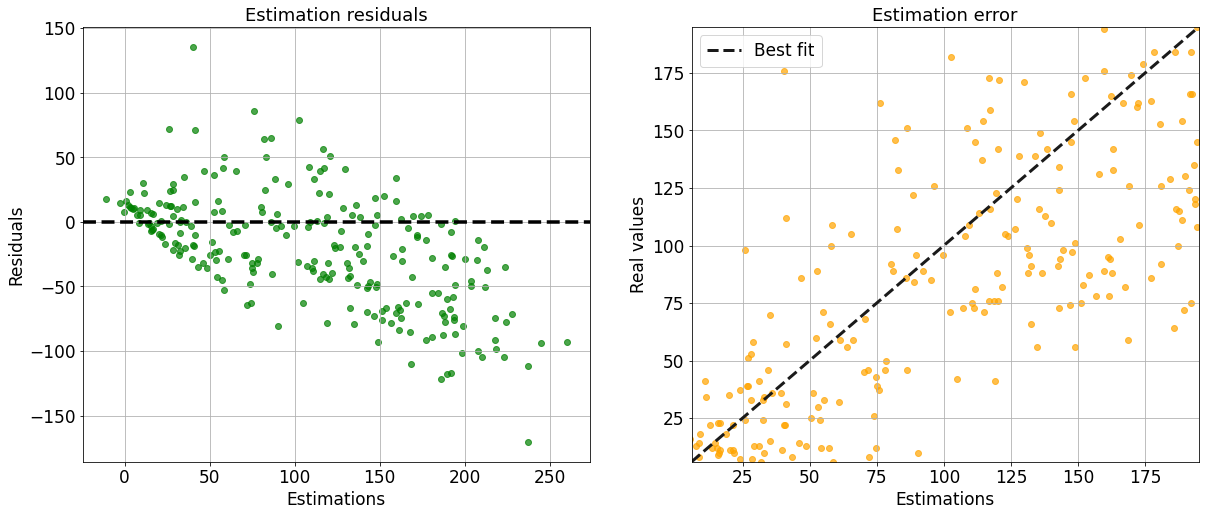

{'data': 'training', 'MSE': 2733.44, 'RMSE': 52.28, 'R2': 0.66, 'MAE': 38.96}
{'data': 'test', 'MSE': 2308.87, 'RMSE': 48.05, 'R2': 0.22, 'MAE': 36.59}


In [22]:
train_metrics, test_metrics = evaluate_model(best_model, x_train, y_train, x_test, y_test)

In [26]:
xgb_params = {'n_estimators': [50, 100, 150], 'max_depth': [2, 3, 5],
              'min_child_weight': [1, 2, 3], 'reg_lambda': [1, 2, 3]}
best_model, grid_results = train_xgboost(x_train, y_train, parameters=xgb_params)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best model score: 
MSE: 3462.39
RMSE: 58.84
Best model parameters: 
{'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 50, 'reg_lambda': 1}


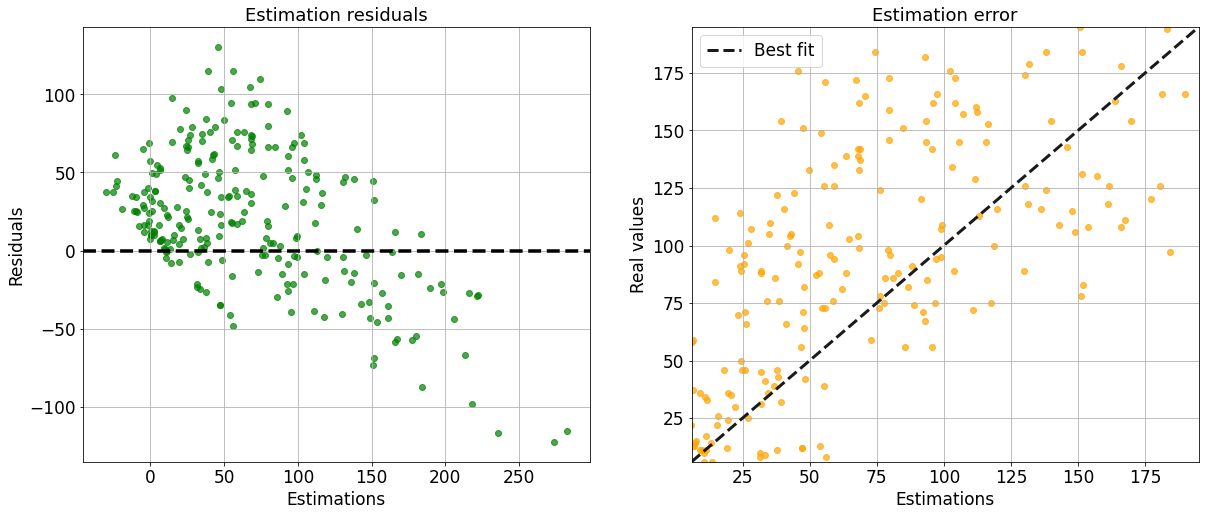

{'data': 'training', 'MSE': 2514.74, 'RMSE': 50.15, 'R2': 0.69, 'MAE': 36.74}
{'data': 'test', 'MSE': 2282.34, 'RMSE': 47.77, 'R2': 0.23, 'MAE': 38.05}


In [27]:
train_metrics, test_metrics = evaluate_model(best_model, x_train, y_train, x_test, y_test)

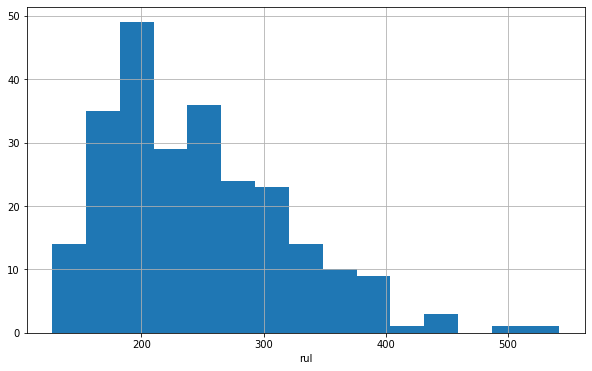

In [69]:
plot_histogram(data, 'rul')

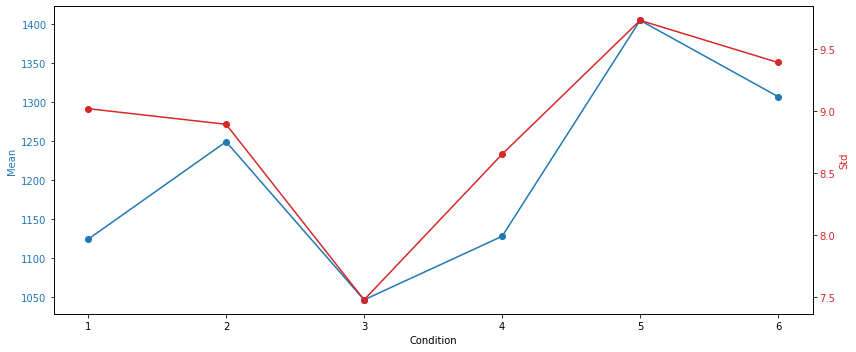

    sensor_name         mean       std  condition
3      sensor_4  1124.490963  9.019432          1
24     sensor_4  1249.568890  8.893205          2
45     sensor_4  1046.772438  7.476698          3
66     sensor_4  1128.238337  8.651547          4
87     sensor_4  1405.249438  9.731900          5
108    sensor_4  1307.423831  9.392014          6


In [68]:
plot_condition_stats(conditioned_stats, sensor='sensor_4')

Random units:  [ 20 126 176 196 247  10 228  52   7 157]


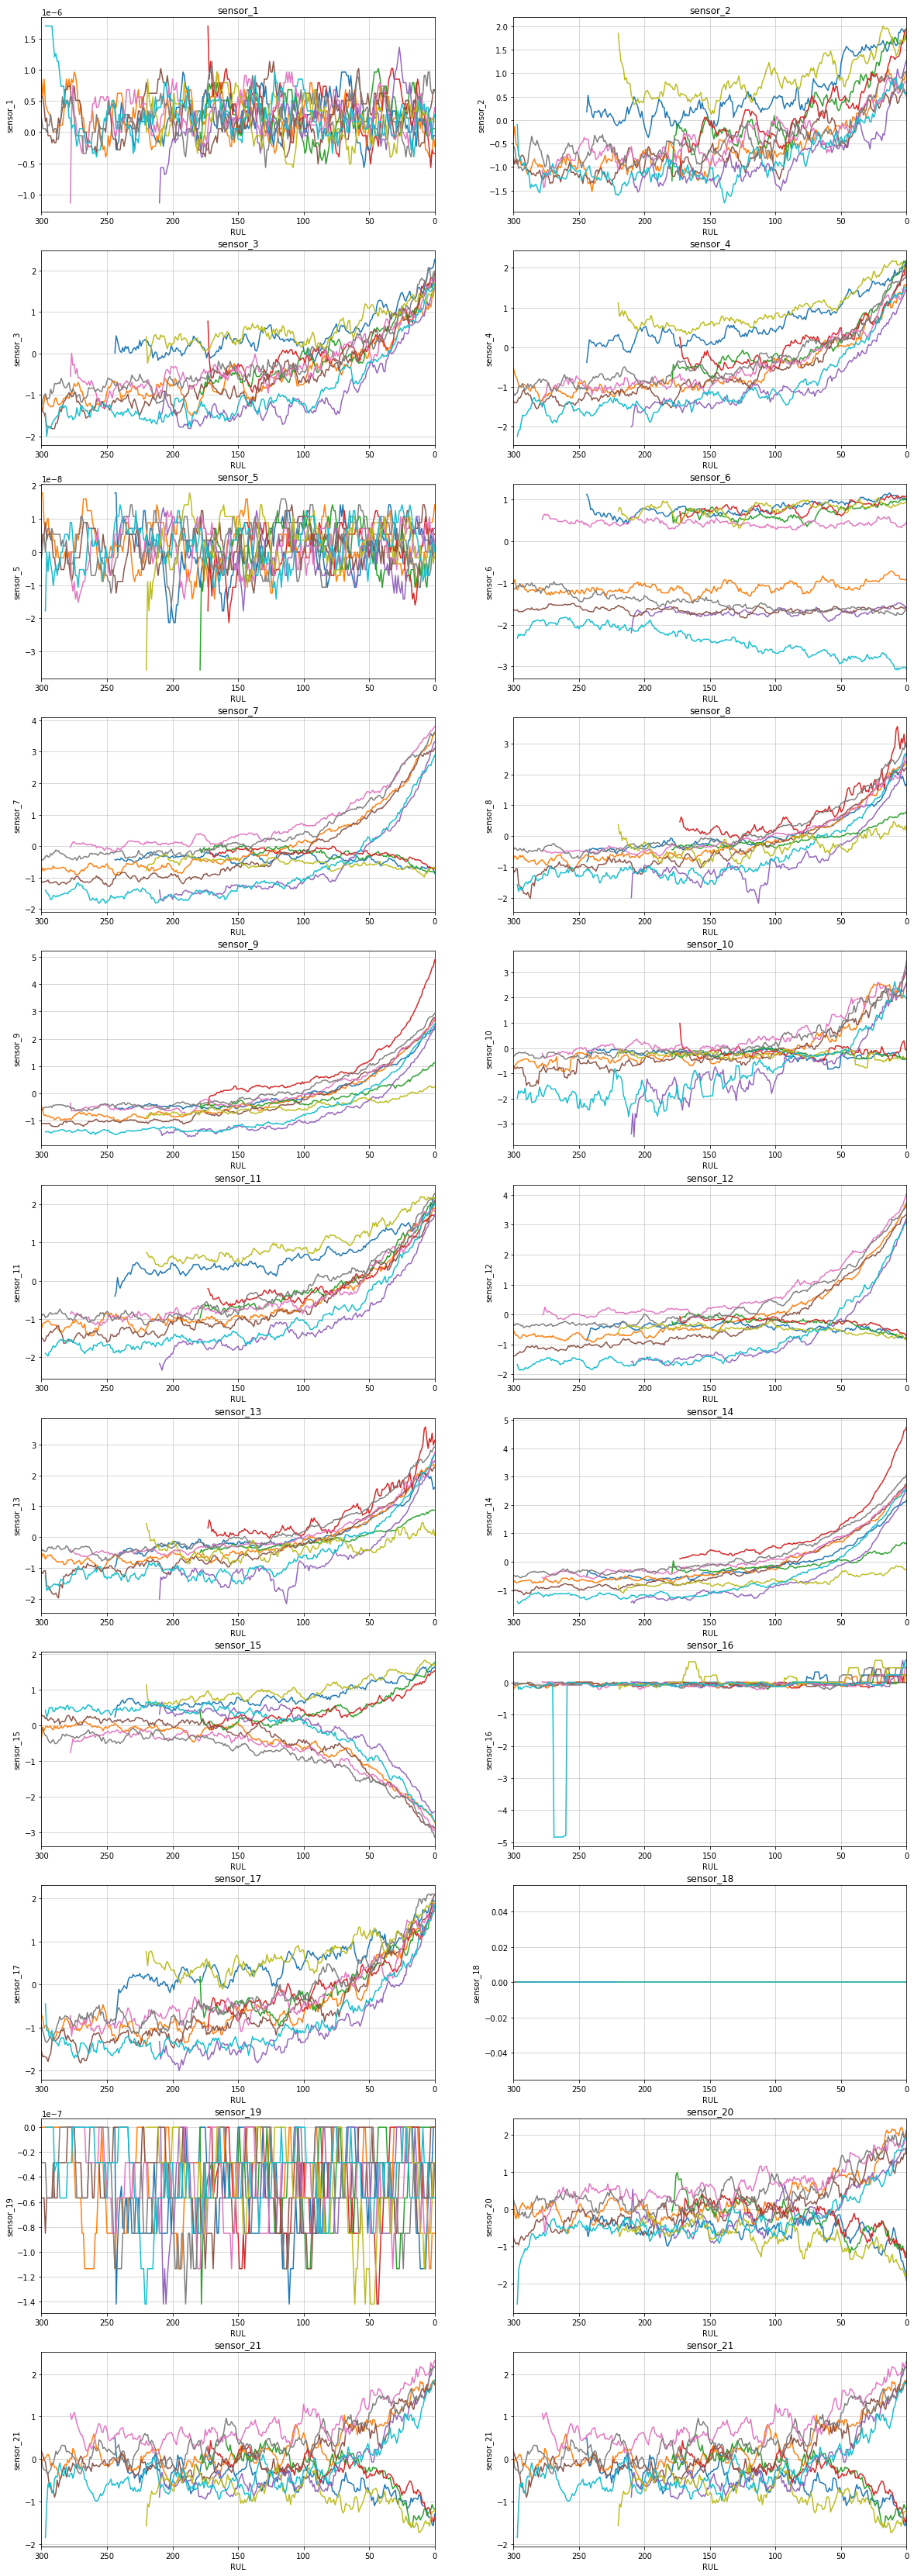

In [65]:
plot_sensors(smoothed_data)

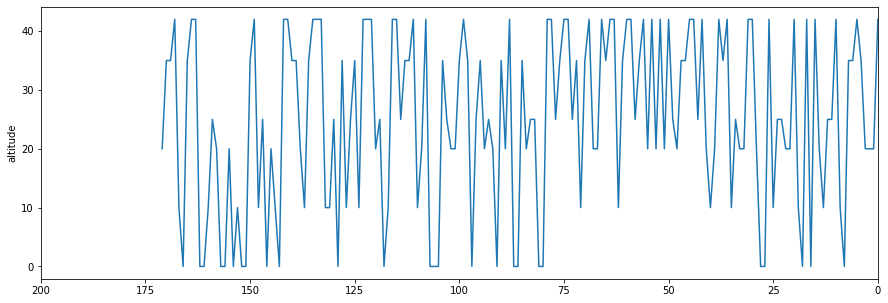

In [65]:
plot_condition(data, unit=50, cond_column='altitude')

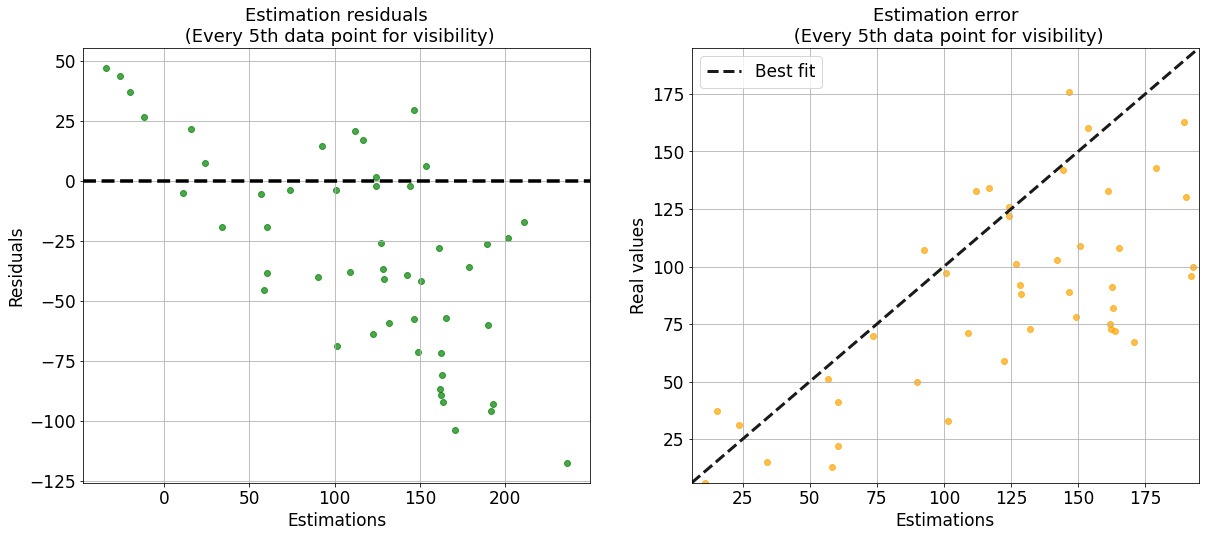

{'data': 'training', 'MSE': 3633.25, 'RMSE': 60.28, 'R2': 0.55, 'MAE': 46.01}
{'data': 'test', 'MSE': 2289.26, 'RMSE': 47.85, 'R2': 0.23, 'MAE': 38.8}


In [70]:
model, train_metrics, test_metrics = train_baseline(data, test_data, test_target)